# Time course growth and substrate  data ➟ Growth parameters
This notebook calculates the growth rate, yield coefficient, and substrate uptake rate of R. opacus cultures growing with phenol and glucose. These experiements were published in these papers: [Yondeda (2016)](https://academic.oup.com/nar/article/44/5/2240/2465306) and [Henson (2018)](https://www.sciencedirect.com/science/article/pii/S1096717618300910).

#### Yoneda data:
* WT 1.5 g/L Phenol (3 trials)
* Evol33 1.5 g/L Phenol (3 trials)
* Evol40 1.5 g/L Phenol (3 trials)
<br><br>
* WT 1.0 g/L Glucose, 1.0 g/l ammonium sulfate (1 trial)
* Evol33 1.0 g/L Glucose, 1.0 g/l ammonium sulfate (1 trial)
* Evol40 1.0 g/L Glucose, 1.0 g/l ammonium sulfate (1 trial)
<br><br>
* WT 1.0 g/L Glucose, 0.05 g/l ammonium sulfate (1 trial)
* Evol33 1.0 g/L Glucose, 0.05 g/l ammonium sulfate (1 trial)
* Evol40 1.0 g/L Glucose, 0.05 g/l ammonium sulfate (1 trial)

#### Henson data:
* WT 0.5 g/L Phenol (3 trials)
* PVHG6 0.5 g/L Phenol (3 trials)

### Method: 
<ol>
<li>Calculate growth rate by finding slope of log(biomass) vs. time</li>
<li>Simulate biomass growth by using timepoints and X = X0e^(mu*t)</li>
<li>Calculate yield coefficient by finding the slope of the biomass generated vs substrate consumed</li>
<li>Calculate substrate uptake rate by dividing the growth rate by the yield coefficient</li>
</ol>

### Notes:
The glucose concentration measurements in the Yoneda data sets seem unrealistically low


#### **Data Labels old vs. new:**
#### Yoneda:
* WT 1.5g/L Phenol, 1.0g/L ammonium sulfate	 	(WT-R) ->**WT-HN-HP**
* Evol33 1.5g/L Phenol, 1.0g/L ammonium sulfate 	(EVOL33-R) ->**EVOL33-HN-HP**
* Evol40 1.5g/L Phenol, 1.0g/L ammonium sulfate 	(EVOL40-R) -> **EVOL40-HN-HP**
* WT 1.0g/L Glucose, 1.0g/L ammonium sulfate 		(WT-G) -> **WT-HN-G**
* Evol33 1.0g/L Glucose, 1.0g/L ammonium sulfate 	(EVOL33-G) -> **EVOL33-HN-G**
* Evol40 1.0g/L Glucose, 1.0g/L ammonium sulfate 	(EVOL40-G) -> **EVOL40-HN-G**
* WT 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(WT-G-N) ->**WT-LN-G**
* Evol33 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(EVOL33-G-N) ->**EVOL33-LN-G**
* Evol40 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(EVOL40-G-N) ->**EVOL40-LN-G**
                                                 
#### Henson:
* WT 0.5g/L Phenol 		(WT-P-R) ->**WT-P**
* PVHG6 0.5g/L  Phenol 	(PVHG6-P-R) ->**PVHG-P**

### Setup imports

In [1]:
#Python packages:
import numpy as np
import sys
import os
import pandas as pd
import cobra
import math
from scipy.stats import linregress
from scipy import mean
import matplotlib.pyplot as plt

#### **Load Yoneda and Henson Data**

In [2]:
from edd_utils import login, export_study, export_metadata
# Study to Download
study_slug = 'biodesign_yoneda_set2'#multiomics-data-for-wt-strain-c157'
study_slug2 = 'biodesign_henson2108'
# EDD server
edd_server = 'public-edd.jbei.org'#agilebiofoundry.org'#'edd.jbei.org'
user       = 'schenkch'

In [5]:
session = login(edd_server=edd_server, user=user)

Password for schenkch:  ···············


In [6]:
#Export data from EDD as 2 dataframes:
df: pd.DataFrame

# filename = TBD
    
try:
    df = export_study(session, study_slug, edd_server=edd_server)
    df2 = export_study(session, study_slug2, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    try:
        df = pd.read_csv(filename)
    except:
        print(f'ERROR! Alternative loading of data from disk at {DISKDF} failed!')
    else:
        print(f'OK! Alternative loading of data from disk at {DISKDF} was successful.')


##### **Set biomass production rate**

In [7]:
GRAMS_BIOMASS_PER_LITER_PER_OD = 0.368 # 1 OD = 0.368 g/L of biomass

##### **Yoneda data**

In [8]:
od_df = df[df['Protocol'].str.contains('OD600')]
od_df.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*od_df.loc[:,'Value']

sub_df = df[df['Protocol'].str.contains('HPLC')]

print(f'substrate data has {len(sub_df)} lines')
print(f'OD data has {len(od_df)} lines')

substrate data has 72 lines
OD data has 63 lines


/usr/local/share/jupyteruser/.pyenv/versions/biod_3.7/lib/python3.7/site-packages/pandas/core/indexing.py:362 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/share/jupyteruser/.pyenv/versions/biod_3.7/lib/python3.7/site-packages/pandas/core/indexing.py:480 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##### **Henson data**

In [9]:
od_Hen_df = df2[df2['Protocol'].str.contains('OD600')]#pd.read_csv(ODfile)
od_Hen_df.loc[:,'Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*od_Hen_df['Value']
sub_Hen_df = df2[df2['Protocol'].str.contains('HPLC')]

print(f'substrate data has {len(sub_Hen_df)} lines')
print(f'OD data has {len(od_Hen_df)} lines')

substrate data has 48 lines
OD data has 60 lines


### Define functions to calculate growth rate, yield coefficient, and substrate uptake rate

stats_for_trial: Calculates parameters and plots data and fit lines for a single trial
<br>
stats_for_condition: Takes in three trial names and calls stats_for_trial for each one.

In [10]:
def stats_for_trial(growth_data, substrate_data, molar_mass, display=False, max_time=0, substrate=''):
    
    biomass_values = growth_data['Biomass Conc']
    biomass_times = growth_data['Hours']
    biomass_init = list(biomass_values)[0]

    substrate_values = substrate_data['Value']*1000/molar_mass
    substrate_times = substrate_data['Hours']
    substrate_init = list(substrate_values)[0]
    
    # growth is the slope of log(biomass) vs. time
    growth_rate, _, _, _, _ = linregress(biomass_times, [math.log(val) for val in biomass_values])
    
    # biomass X = X0*e^(μ*t)
    # This is different from above to ensure that there is a biomass value for every substrate measurement
    biomass_sim = [biomass_init*math.exp(growth_rate*time) for time in substrate_times]
    
    # actual consumption = S0 - S
    sub_consumed = [substrate_init - sub_value for sub_value in substrate_values]
    
    # new biomass X = X0 - X
    biomass_sim_growth = [sim_value - biomass_init for sim_value in biomass_sim ]
    
    # yield is the amount of biomass that can be made from a mmol of substrate
    yield_coeff, _, _, _, _ = linregress(sub_consumed, biomass_sim_growth)

    # S = S0 - (1/yield)*X
    substrate_sim = [substrate_init - 1/yield_coeff*val for val in biomass_sim_growth]
    
    substrate_consumption_rate = (1/yield_coeff) * growth_rate

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    axes[0].plot(biomass_times, biomass_values, 'o', color='black')
    axes[0].plot(substrate_times, biomass_sim, '-', color='black')
    axes[1].plot(substrate_times, substrate_values, 'o', color='blue')
    axes[1].plot(substrate_times, substrate_sim, '-', color='blue')
    axes[0].set_title('Biomass growth')
    axes[1].set_title(f'{substrate} consumption')
    axes[0].set_xlabel('Time (hr)')
    axes[1].set_xlabel('Time (hr)')
    axes[0].set_ylabel('Biomass (g/L)')
    axes[1].set_ylabel(f'{substrate} (mmol/L)')
    fig.tight_layout()
    
    if display:
        print(f'growth_rate = {growth_rate:.3f} hr-1')
        print(f'yield coefficient = {yield_coeff:.3f} g biomass / mmol substrate')
        print(f'substrate consumption rate = {substrate_consumption_rate:.3f} mmol substrate/gram biomass * hr')
        return growth_rate, yield_coeff, substrate_consumption_rate
    else:
        return growth_rate, yield_coeff, substrate_consumption_rate
    
    
    
def stats_for_condtion(od_df, sub_df, trial_1, trial_2, trial_3, molar_mass, substrate='', max_time=0):
    
    if max_time != 0:
        od_df = od_df[od_df['Hours'] < max_time]
        sub_df = sub_df[sub_df['Hours'] < max_time]
        
    od_1 = od_df[od_df['Line Name'] == trial_1]
    sub_1 = sub_df[sub_df['Line Name'] == trial_1]

    od_2 = od_df[od_df['Line Name'] == trial_2]
    sub_2 = sub_df[sub_df['Line Name'] == trial_2]

    od_3 = od_df[od_df['Line Name'] == trial_3]
    sub_3 = sub_df[sub_df['Line Name'] == trial_3]

    gr_1, yc_1, scr_1 = stats_for_trial(od_1, sub_1, molar_mass, substrate=substrate)
    gr_2, yc_2, scr_2 = stats_for_trial(od_2, sub_2, molar_mass, substrate=substrate)
    gr_3, yc_3, scr_3 = stats_for_trial(od_3, sub_3, molar_mass, substrate=substrate)
    
    growth_rate = np.average([gr_1, gr_2, gr_3])
    yield_coeff = np.average([yc_1, yc_2, yc_3])
    substrate_consumption_rate = np.average([scr_1, scr_2, scr_3])
    growth_rate_std = np.std([gr_1, gr_2, gr_3])
    yield_coeff_std = np.std([yc_1, yc_2, yc_3])
    substrate_consumption_rate_std = np.std([scr_1, scr_2, scr_3])
    
    print(f'growth_rate = {growth_rate:.3f} ± {growth_rate_std:.3f} hr-1')
    print(f'yield coefficient = {yield_coeff:.3f} ± {yield_coeff_std:.3f} g biomass / mmol substrate')
    print(f'substrate consumption rate = {substrate_consumption_rate:.3f} ± {substrate_consumption_rate_std:.3f} mmol substrate/gram biomass * hr')
    return growth_rate, yield_coeff, substrate_consumption_rate, growth_rate_std, yield_coeff_std, substrate_consumption_rate_std 

#### **Create dataframe and add results**

In [11]:
#create dataframe for all results:
indlist = ['growth rate', 'yield coefficient',  'substrate consumption rate', 'growth rate std dev', 'yield coefficient std dev', 'substrate consumption rate std dev']
strainslist = ['WT-HN-HP','EVOL33-HN-HP', 'EVOL40-HN-HP', 'WT-HN-G', 'EVOL33-HN-G', 'EVOL40-HN-G',  'WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G', 'WT-P', 'PVHG-P']

In [12]:
growthandsubstrdata = pd.DataFrame(index=strainslist, columns=indlist, dtype=float)
growthandsubstrdata

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev
WT-HN-HP,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-HN-HP,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-HN-HP,NaN,NaN,NaN,NaN,NaN,NaN
WT-HN-G,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-HN-G,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-HN-G,NaN,NaN,NaN,NaN,NaN,NaN
WT-LN-G,NaN,NaN,NaN,NaN,NaN,NaN
EVOL33-LN-G,NaN,NaN,NaN,NaN,NaN,NaN
EVOL40-LN-G,NaN,NaN,NaN,NaN,NaN,NaN
WT-P,NaN,NaN,NaN,NaN,NaN,NaN


### Yoneda: WT 1.5 g/L Phenol, 1.0g/L ammonium sulfate - WT-HN-HP

growth_rate = 0.019 ± 0.001 hr-1
yield coefficient = 0.028 ± 0.003 g biomass / mmol substrate
substrate consumption rate = 0.668 ± 0.031 mmol substrate/gram biomass * hr


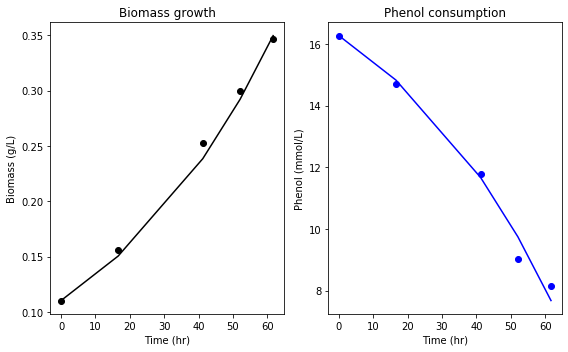

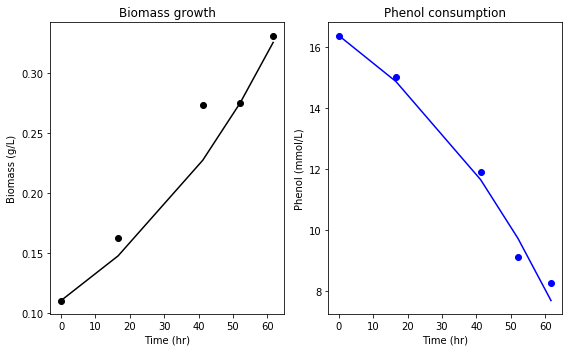

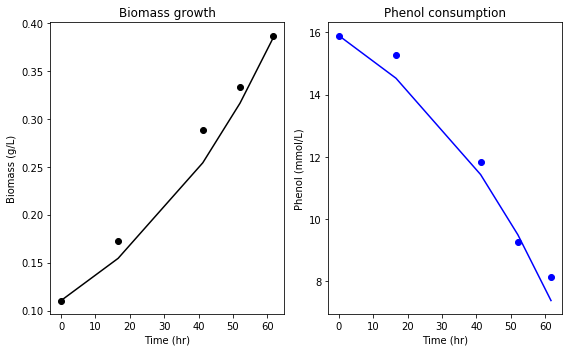

In [13]:
growth_rate_WTHNHP, yield_coeff_WTHNHP, substrate_consumption_rate_WTHNHP, growth_rate_std_WTHNHP, yield_coeff_std_WTHNHP, substrate_consumption_rate_std_WTHNHP = stats_for_condtion(od_df, sub_df, 'WT-R1', 'WT-R2', 'WT-R3', 94.11, substrate='Phenol')

##### **Add results to dataframe**

In [14]:
growthandsubstrdata.at['WT-HN-HP',:]=[growth_rate_WTHNHP, yield_coeff_WTHNHP, substrate_consumption_rate_WTHNHP, growth_rate_std_WTHNHP, yield_coeff_std_WTHNHP, substrate_consumption_rate_std_WTHNHP]

### Yoneda: Evol33 1.5 g/L Phenol, 1.0g/L ammonium sulfate - EVOL33-HN-HP

growth_rate = 0.034 ± 0.002 hr-1
yield coefficient = 0.035 ± 0.002 g biomass / mmol substrate
substrate consumption rate = 0.964 ± 0.020 mmol substrate/gram biomass * hr


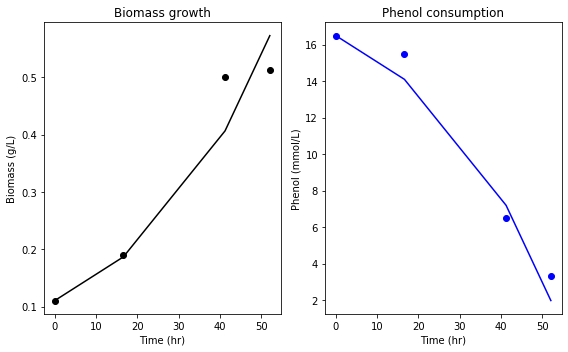

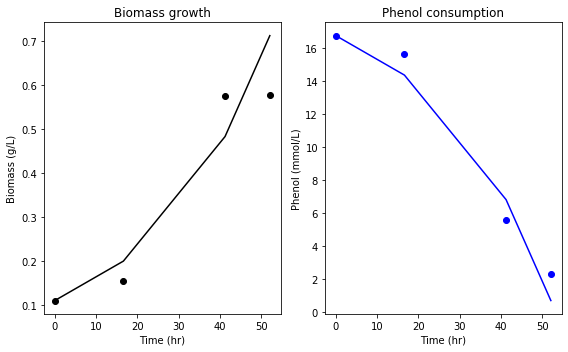

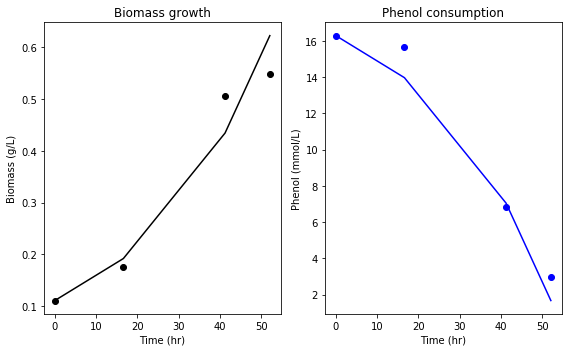

In [15]:
growth_rate_EVOL33HNHP, yield_coeff_EVOL33HNHP, substrate_consumption_rate_growth_rate_EVOL33HNHP, growth_rate_std_EVOL33HNHP, yield_coeff_std_EVOL33HNHP, substrate_consumption_rate_std_EVOL33HNHP = stats_for_condtion(od_df, sub_df, 'EVOL33-R1', 'EVOL33-R2', 'EVOL33-R3', 94.11, substrate='Phenol', max_time=60)

##### **Add results to dataframe**

In [16]:
growthandsubstrdata.at['EVOL33-HN-HP',:]=[growth_rate_EVOL33HNHP, yield_coeff_EVOL33HNHP, substrate_consumption_rate_growth_rate_EVOL33HNHP, growth_rate_std_EVOL33HNHP, yield_coeff_std_EVOL33HNHP, substrate_consumption_rate_std_EVOL33HNHP]

### Yoneda: Evol40 1.5 g/L Phenol,, 1.0g/L ammonium sulfate - EVOL40-HN-HP

growth_rate = 0.034 ± 0.001 hr-1
yield coefficient = 0.038 ± 0.002 g biomass / mmol substrate
substrate consumption rate = 0.897 ± 0.029 mmol substrate/gram biomass * hr


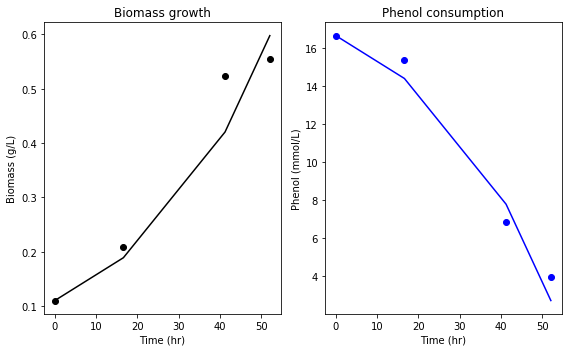

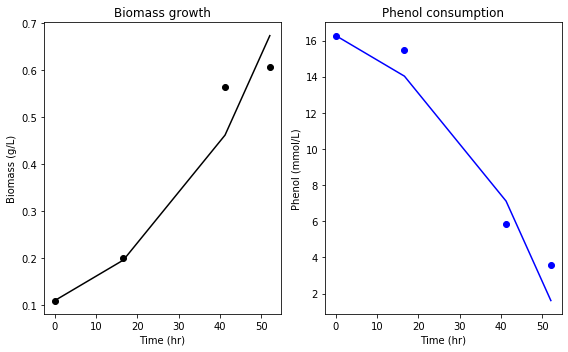

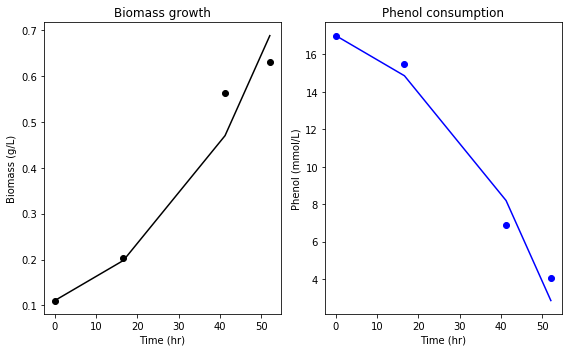

In [17]:
growth_rate_EVOL40HNHP, yield_coeff_EVOL40HNHP, substrate_consumption_rate_EVOL40HNHP, growth_rate_std_EVOL40HNHP, yield_coeff_std_EVOL40HNHP, substrate_consumption_rate_std_EVOL40HNHP = stats_for_condtion(od_df, sub_df, 'EVOL40-R1', 'EVOL40-R2', 'EVOL40-R3', 94.11, substrate='Phenol', max_time=60)

##### **Add results to dataframe**

In [18]:
growthandsubstrdata.at['EVOL40-HN-HP',:]=[growth_rate_EVOL40HNHP, yield_coeff_EVOL40HNHP, substrate_consumption_rate_EVOL40HNHP, growth_rate_std_EVOL40HNHP, yield_coeff_std_EVOL40HNHP, substrate_consumption_rate_std_EVOL40HNHP]

### Yoneda: WT 1.0 g/L Glucose, 1.0 g/l ammonium sulfate - WT-HN-G

growth_rate = 0.032 hr-1
yield coefficient = 1.209 g biomass / mmol substrate
substrate consumption rate = 0.026 mmol substrate/gram biomass * hr


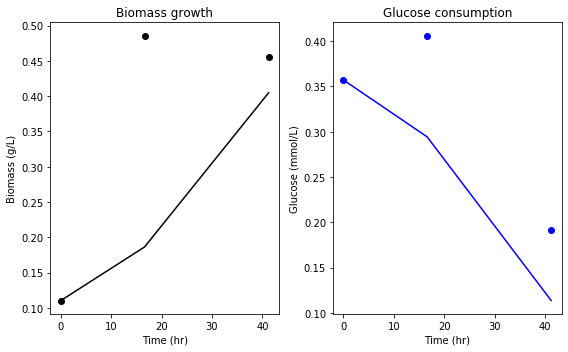

In [19]:
od_1 = od_df[od_df['Line Name'] == 'WT-G']
sub_1 = sub_df[sub_df['Line Name'] == 'WT-G']

growth_rate_WTHNG, yield_coeff_WTHNG, substrate_consumption_rate_WTHNG = stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

##### **Add results to dataframe**

In [20]:
growthandsubstrdata.at['WT-HN-G',:]=[growth_rate_WTHNG, yield_coeff_WTHNG, substrate_consumption_rate_WTHNG, 0, 0, 0]

### Yoneda: Evol33 1.0 g/L Glucose, 1.0 g/l ammonium sulfate - EVOL33-HN-G

growth_rate = 0.031 hr-1
yield coefficient = 0.763 g biomass / mmol substrate
substrate consumption rate = 0.041 mmol substrate/gram biomass * hr


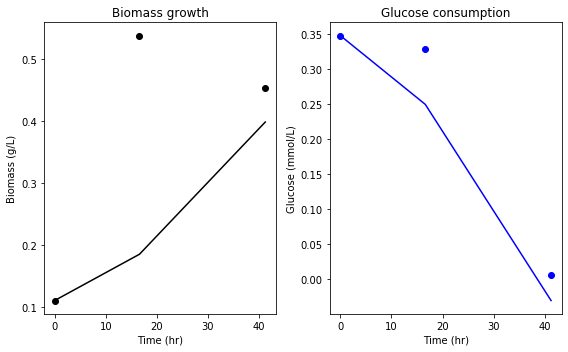

In [21]:
od_1 = od_df[od_df['Line Name'] == 'EVOL33-G']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL33-G']
growth_rate_EVOL33HNG, yield_coeff_EVOL33HNG, substrate_consumption_rate_EVOL33HNG = stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

##### **Add results to dataframe**

In [22]:
growthandsubstrdata.at['EVOL33-HN-G',:]=[growth_rate_EVOL33HNG, yield_coeff_EVOL33HNG, substrate_consumption_rate_EVOL33HNG, 0, 0, 0]

### Yoneda: Evol40 1.0 g/L Glucose, 1.0 g/l ammonium sulfate - EVOL40-HN-G

growth_rate = 0.031 hr-1
yield coefficient = -0.526 g biomass / mmol substrate
substrate consumption rate = -0.059 mmol substrate/gram biomass * hr


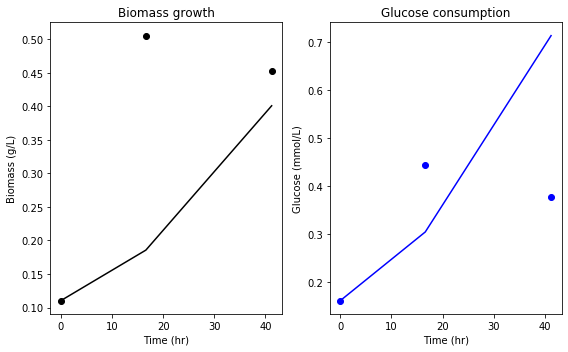

In [23]:
od_1 = od_df[od_df['Line Name'] == 'EVOL40-G']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL40-G']
growth_rate_EVOL40HNG, yield_coeff_EVOL40HNG, substrate_consumption_rate_EVOL40HNG = stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

##### **Add results to dataframe**

In [24]:
growthandsubstrdata.at['EVOL40-HN-G',:]=[growth_rate_EVOL40HNG, yield_coeff_EVOL40HNG, substrate_consumption_rate_EVOL40HNG, 0, 0, 0]

### Yoneda: WT 1.0 g/L Glucose, 0.05 g/l ammonium sulfate - WT-LN-G

growth_rate = 0.039 hr-1
yield coefficient = 1.928 g biomass / mmol substrate
substrate consumption rate = 0.020 mmol substrate/gram biomass * hr


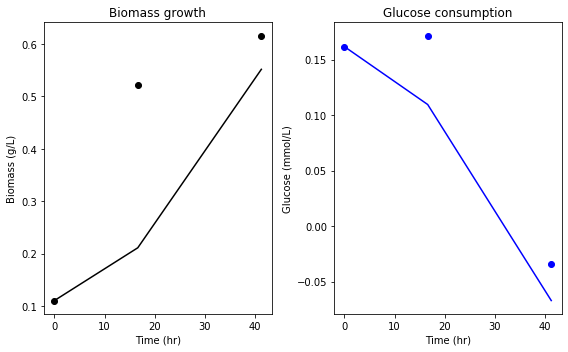

In [25]:
od_1 = od_df[od_df['Line Name'] == 'WT-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'WT-G-N']
growth_rate_WTLNG, yield_coeff_WTLNG, substrate_consumption_rate_WTLNG = stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

##### **Add results to dataframe**

In [26]:
growthandsubstrdata.at['WT-LN-G',:]=[growth_rate_WTLNG, yield_coeff_WTLNG, substrate_consumption_rate_WTLNG, 0, 0, 0]

### Yoneda: Evol33 1.0 g/L Glucose, 0.05 g/l ammonium sulfate  - EVOL33-LN-G

growth_rate = 0.033 hr-1
yield coefficient = 1.058 g biomass / mmol substrate
substrate consumption rate = 0.031 mmol substrate/gram biomass * hr


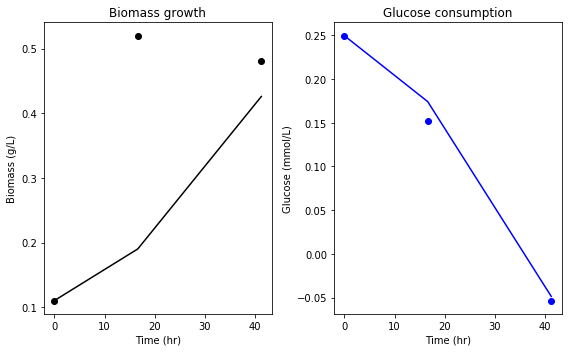

In [27]:
od_1 = od_df[od_df['Line Name'] == 'EVOL33-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL33-G-N']
growth_rate_EVOL33LNG, yield_coeff_EVOL33LNG, substrate_consumption_rate_EVOL33LNG = stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

##### **Add results to dataframe**

In [28]:
growthandsubstrdata.at['EVOL33-LN-G',:]=[growth_rate_EVOL33LNG, yield_coeff_EVOL33LNG, substrate_consumption_rate_EVOL33LNG, 0, 0, 0]

### Yoneda: Evol40 1.0 g/L Glucose, 0.05 g/l ammonium sulfate  - EVOL40-LN-G

growth_rate = 0.034 hr-1
yield coefficient = 2.133 g biomass / mmol substrate
substrate consumption rate = 0.016 mmol substrate/gram biomass * hr


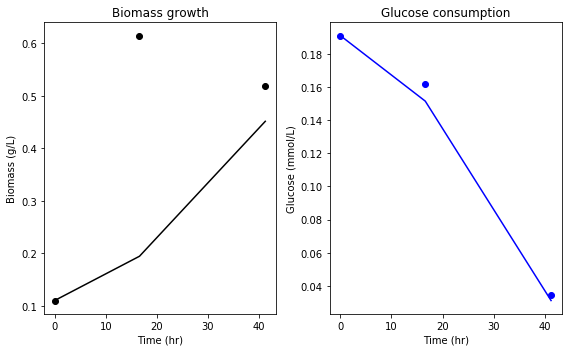

In [29]:
od_1 = od_df[od_df['Line Name'] == 'EVOL40-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL40-G-N']
growth_rate_EVOL40LNG, yield_coeff_EVOL40LNG, substrate_consumption_rate_EVOL40LNG = stats_for_trial(od_1, sub_1, 180.16, display=True, substrate='Glucose')

##### **Add results to dataframe**

In [30]:
growthandsubstrdata.at['EVOL40-LN-G',:]=[growth_rate_EVOL40LNG, yield_coeff_EVOL40LNG, substrate_consumption_rate_EVOL40LNG, 0, 0, 0]

### Henson: WT 0.5 g/L Phenol - WT-P 

growth_rate = 0.065 ± 0.001 hr-1
yield coefficient = 0.049 ± 0.005 g biomass / mmol substrate
substrate consumption rate = 1.352 ± 0.122 mmol substrate/gram biomass * hr


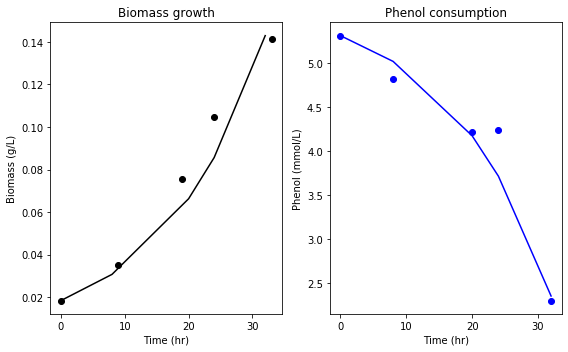

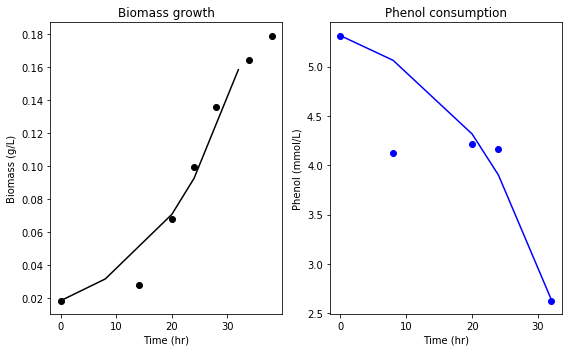

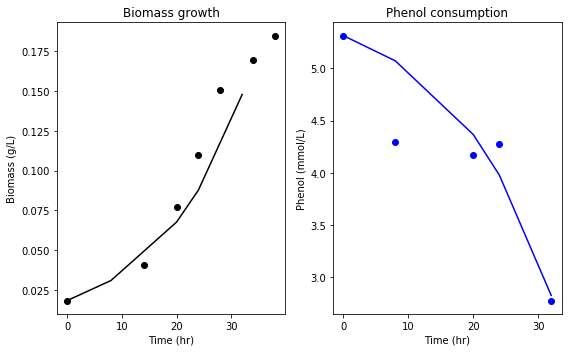

In [31]:
growth_rate_WTP, yield_coeff_WTP, substrate_consumption_rate_WTP, growth_rate_std_WTP, yield_coeff_std_WTP, substrate_consumption_rate_std_WTP  = stats_for_condtion(od_Hen_df, sub_Hen_df,'WT-P-R1', 'WT-P-R2', 'WT-P-R3', 94.11, substrate='Phenol' ,max_time = 40)

##### **Add results to dataframe**

In [32]:
growthandsubstrdata.at['WT-P',:]=[growth_rate_WTP, yield_coeff_WTP, substrate_consumption_rate_WTP, growth_rate_std_WTP, yield_coeff_std_WTP, substrate_consumption_rate_std_WTP]

### Henson: PVHG6 0.5 g/L Phenol - PVHG-P

growth_rate = 0.080 ± 0.003 hr-1
yield coefficient = 0.041 ± 0.002 g biomass / mmol substrate
substrate consumption rate = 1.967 ± 0.022 mmol substrate/gram biomass * hr


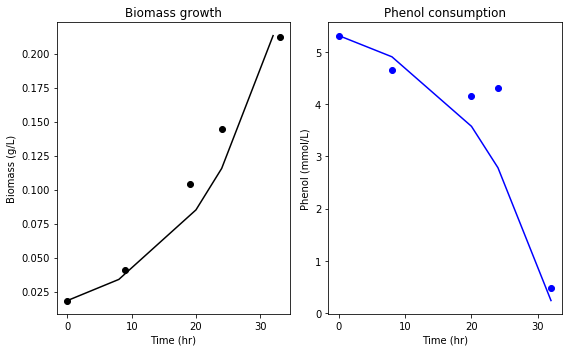

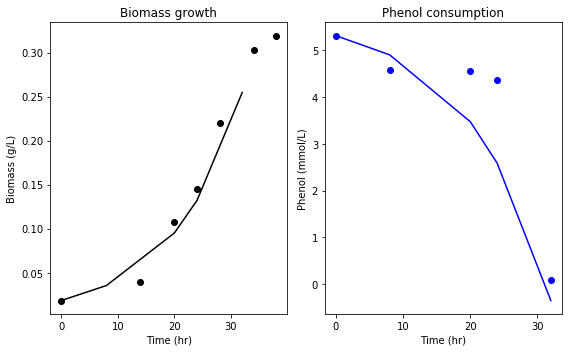

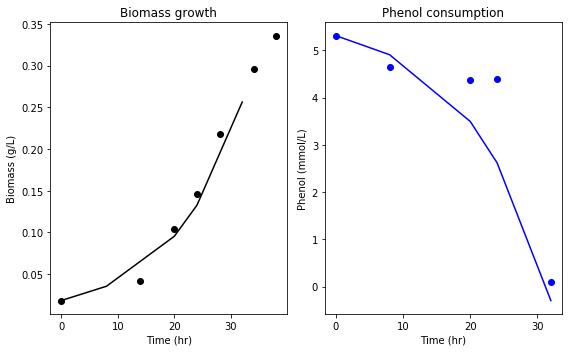

In [33]:
growth_rate_PVHGP, yield_coeff_PVHGP, substrate_consumption_rate_PVHGP, growth_rate_std_PVHGP, yield_coeff_std_PVHGP, substrate_consumption_rate_std_PVHGP  = stats_for_condtion(od_Hen_df, sub_Hen_df, 'PVHG6-P-R1', 'PVHG6-P-R2', 'PVHG6-P-R3', 94.11, substrate='Phenol', max_time=40)

##### **Add results to dataframe**

In [34]:
growthandsubstrdata.at['PVHG-P',:]=[growth_rate_PVHGP, yield_coeff_PVHGP, substrate_consumption_rate_PVHGP, growth_rate_std_PVHGP, yield_coeff_std_PVHGP, substrate_consumption_rate_std_PVHGP]

### Glucose 2018 data

In [35]:
od_glu_filename = "OpacusBiodesign/EDD_glucose_2018_data/2018_OD_data.csv"
substrate_glu_filename = "OpacusBiodesign/EDD_glucose_2018_data/2018_metabolomics_data.csv"

od_glu_df = pd.read_csv(od_glu_filename)
sub_glu_df = pd.read_csv(substrate_glu_filename)

od_glu_df['Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*od_glu_df['Value']

print(f'substrate data has {len(sub_glu_df)} lines')
print(f'OD data has {len(od_glu_df)} lines')

substrate data has 12 lines
OD data has 12 lines


In [36]:
od_glu_df = od_glu_df.rename({'Time': 'Hours'}, axis=1)
sub_glu_df = sub_glu_df.rename({'Time': 'Hours'}, axis=1)

growth_rate = 0.260 ± 0.005 hr-1
yield coefficient = 0.073 ± 0.004 g biomass / mmol substrate
substrate consumption rate = 3.582 ± 0.142 mmol substrate/gram biomass * hr


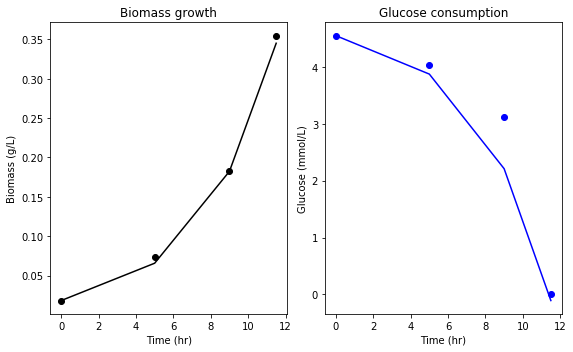

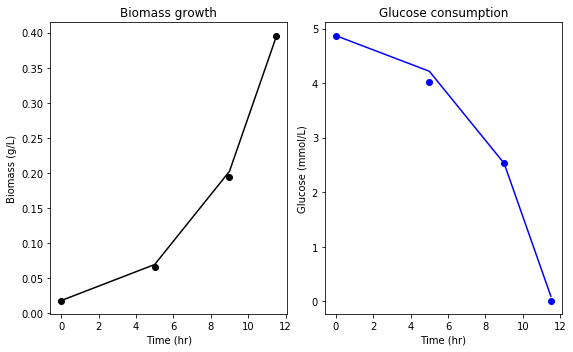

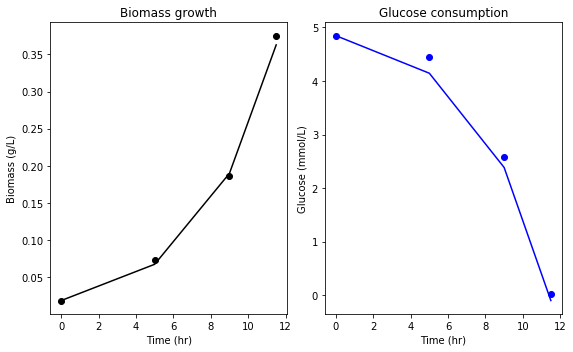

In [37]:
growth_rate_WTLNG2, yield_coeff_WTLNG2, substrate_consumption_rate_WTLNG2, growth_rate_std_WTLNG2, yield_coeff_std_WTLNG2, substrate_consumption_rate_std_WTLNG2  = stats_for_condtion(od_glu_df, sub_glu_df, 'WT-R1', 'WT-R2', 'WT-R3', 180.16, substrate='Glucose', max_time=12)

##### **Add results to dataframe**

In [38]:
growthandsubstrdata.at['WT-LN-G-2',:]=[growth_rate_WTLNG2, yield_coeff_WTLNG2, substrate_consumption_rate_WTLNG2, growth_rate_std_WTLNG2, yield_coeff_std_WTLNG2, substrate_consumption_rate_std_WTLNG2]

In [39]:
growthandsubstrdata

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev
WT-HN-HP,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269
EVOL33-HN-HP,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354
EVOL40-HN-HP,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558
WT-HN-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000
EVOL33-HN-G,0.031149,0.763357,0.040805,0.000000,0.000000,0.000000
EVOL40-HN-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000
WT-LN-G,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000
EVOL33-LN-G,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000
EVOL40-LN-G,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279


##### **Write data frame to file**

In [40]:
growthandsubstrdata.to_csv('OpacusBiodesign/Biodesign_gr/consumption_and_growth_data/consumption_and_growth_data_new.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../../consumption_and_growth_data/consumption_and_growth_data_new.csv'